In [1]:
import glob
import re
from collections import defaultdict

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import torch
from tqdm import tqdm

from analysis.result_loading import load_and_combine_vw_models
from configuration.configurable_factory import resolve_configurable_factories
from envs.gym_make import get_cartpole_env_config, get_acrobot_env_config, get_lunar_lander_env_config
from experiments.paths import RESULTS_DIR
from experiments.utils.load_avril_demos import load_avril_demonstrations
# from experiments.birl.presets.safety_gym_presets import get_safegym_pt_goal_l1_config

/home/ob/venv/irl-torch/lib/python3.10/site-packages/ray/data/__init__.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources._vendor.packaging.version import parse as parse_version
/home/ob/dev/irl-torch/irl_algorithms/demonstrations_config.py:34: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  @pydantic.validator("total_samples")
/home/ob/venv/irl-torch/lib/python3.10/site-packages/pydantic/_internal/_config.py:271: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydant

In [2]:
# Models were evaluated with the following numbers of expert trajectories
traj_nums = [1,3,7,10,15]

## 0. Functions
Let's define a few functions that we'll use for model evaluation and result plotting.

The following function tests a reward model (mainly consisting of a MCMC sample of parameters of the approximate Q-function) on an environment, and returns the rewards obtained by the model:

In [85]:
def gym_test(reward_model, env_name, num_actions, test_evals=300, aggregation_fn=lambda x: torch.median(x, dim=-1)[0]):
    results = []
    env = gym.make(env_name)
    for t in tqdm(range(test_evals), desc="Testing"):
        observation, info = env.reset()
        done = truncated = False
        rewards = []
        while not (done or truncated):
            logit = aggregation_fn(reward_model.q_samples(torch.from_numpy(observation).float().unsqueeze(0), torch.eye(num_actions, dtype=torch.float)))
            # logit = torch.randn_like(logit)
            action = torch.argmax(logit, dim=1)
            observation, reward, done, truncated, info = env.step(int(action))
            rewards.append(reward)

        results.append(sum(rewards))
    env.close()
    mean_res = sum(results) / test_evals
    print(f"Mean Reward: {mean_res}")
    
    plt.hist(results, bins=10)

    return results

The following function tests a random policy on an environment, and returns the rewards obtained by the policy:

In [28]:
def gym_test_random_policy(env_name, test_evals=1000):
    results = []
    env = gym.make(env_name)
    for t in tqdm(range(test_evals), desc="Testing"):
        observation, info = env.reset()
        done = truncated = False
        rewards = []
        while not (done or truncated):
            # logit = torch.randn_like(logit)
            action = np.random.randint(0, env_config.a_dim)
            observation, reward, done, truncated, info = env.step(int(action))
            rewards.append(reward)

        results.append(sum(rewards))
    env.close()
    mean_res = sum(results) / test_evals
    print(f"Mean Reward: {mean_res}")
    
    plt.hist(results, bins=10)

    return results

## 1. Cartpole results

In [76]:
beta = 3.
env_config = get_cartpole_env_config()

In [108]:
# list files in the result folder:
all_results = [file_name for file_name in glob.glob(str(RESULTS_DIR / "birl/06b_vw_cartpole*_paper_*.pt")) 
               if "_10s_" not in file_name and 
               "info" not in file_name and 
               ".checkpoint." not in file_name and 
               "evaluation" not in file_name]
all_results

['/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_10t_hl8_split4_paper_240614-135537.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_3t_hl8_split1_paper_240611-162605.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_15t_hl8_split0_paper_240614-132149.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_1t_hl8_split2_paper_240611-114556.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_1t_hl8_split3_paper_240611-124038.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_7t_hl8_split3_paper_240613-030637.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_3t_hl8_split4_paper_240611-154433.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_3t_hl8_split3_paper_240611-200418.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_10t_hl8_split0_paper_240616-202655.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_10t_hl8_split1_paper_240615-042109.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_1

Testing: 100%|██████████| 1000/1000 [00:00<00:00, 6339.12it/s]

Mean Reward: 23.005


23.005

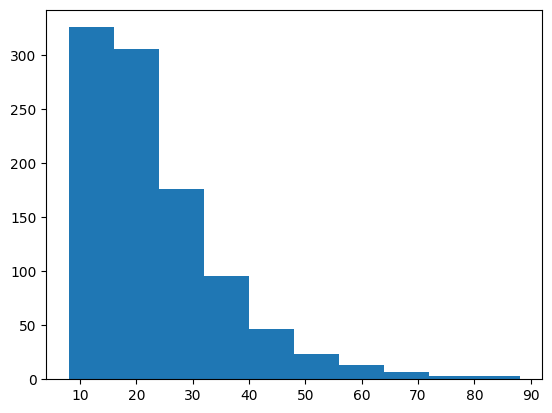

In [109]:
random_policy_rewards = gym_test_random_policy(env_config.env_name)
np.mean(random_policy_rewards)

In [110]:
# Separate files by number of trajectories and split
result_files = defaultdict(lambda: defaultdict(list))
vw_models = defaultdict(lambda: defaultdict(list))

for file_name in all_results:
    res = re.search(r"_(\d+)t_hl8_split(\d)_", file_name)
    if res is None:
        continue
    n_trajectories, split = res.groups()
    result_files[int(n_trajectories)][int(split)].append(file_name)
result_files

defaultdict(<function __main__.<lambda>()>,
            {10: defaultdict(list,
                         {4: ['/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_10t_hl8_split4_paper_240614-135537.pt',
                           '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_10t_hl8_split4_paper_240617-083915.pt',
                           '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_10t_hl8_split4_paper_240615-232226.pt'],
                          0: ['/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_10t_hl8_split0_paper_240616-202655.pt',
                           '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_10t_hl8_split0_paper_240614-140947.pt',
                           '/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_10t_hl8_split0_paper_240615-200546.pt'],
                          1: ['/home/ob/results/irl-torch/birl/06b_vw_cartpole_loop_10t_hl8_split1_paper_240615-042109.pt',
                           '/home/ob/results/irl-torch/birl/06b

### Evaluate merged models
The MCMC sampling was done over multiple parallel chain. Load the different chains for each number of expert trajectories and each split and merge them into a single model. This model is then evaluated on the environment.

10 trajectories, split 4: Loaded a model with params of shape torch.Size([2143, 65]) from 3 files.


Testing: 100%|██████████| 300/300 [01:00<00:00,  4.99it/s]


Mean Reward: 500.0
10 trajectories, split 0: Loaded a model with params of shape torch.Size([2143, 65]) from 3 files.


Testing: 100%|██████████| 300/300 [00:57<00:00,  5.21it/s]


Mean Reward: 500.0
10 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 65]) from 2 files.


Testing: 100%|██████████| 300/300 [01:00<00:00,  4.93it/s]


Mean Reward: 500.0
10 trajectories, split 2: Loaded a model with params of shape torch.Size([2143, 65]) from 3 files.


Testing: 100%|██████████| 300/300 [00:55<00:00,  5.41it/s]


Mean Reward: 500.0
10 trajectories, split 3: Loaded a model with params of shape torch.Size([2143, 65]) from 3 files.


Testing: 100%|██████████| 300/300 [00:53<00:00,  5.56it/s]


Mean Reward: 500.0
3 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 65]) from 4 files.


Testing: 100%|██████████| 300/300 [01:04<00:00,  4.63it/s]


Mean Reward: 500.0
3 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 65]) from 4 files.


Testing: 100%|██████████| 300/300 [00:57<00:00,  5.19it/s]


Mean Reward: 497.15
3 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 65]) from 4 files.


Testing: 100%|██████████| 300/300 [01:03<00:00,  4.76it/s]


Mean Reward: 497.27666666666664
3 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 65]) from 4 files.


Testing: 100%|██████████| 300/300 [01:01<00:00,  4.87it/s]


Mean Reward: 500.0
3 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 65]) from 4 files.


Testing: 100%|██████████| 300/300 [00:56<00:00,  5.30it/s]


Mean Reward: 468.5933333333333
15 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 65]) from 2 files.


Testing: 100%|██████████| 300/300 [00:57<00:00,  5.19it/s]


Mean Reward: 500.0
15 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 65]) from 2 files.


Testing: 100%|██████████| 300/300 [00:56<00:00,  5.34it/s]


Mean Reward: 474.7866666666667
15 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 65]) from 2 files.


Testing: 100%|██████████| 300/300 [00:59<00:00,  5.01it/s]


Mean Reward: 500.0
15 trajectories, split 4: Loaded a model with params of shape torch.Size([2500, 65]) from 1 files.


Testing: 100%|██████████| 300/300 [00:58<00:00,  5.10it/s]


Mean Reward: 500.0
15 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 65]) from 2 files.


Testing: 100%|██████████| 300/300 [00:56<00:00,  5.30it/s]


Mean Reward: 500.0
1 trajectories, split 2: Loaded a model with params of shape torch.Size([2084, 65]) from 5 files.


Testing: 100%|██████████| 300/300 [00:57<00:00,  5.18it/s]


Mean Reward: 500.0
1 trajectories, split 3: Loaded a model with params of shape torch.Size([2084, 65]) from 5 files.


Testing: 100%|██████████| 300/300 [00:54<00:00,  5.50it/s]


Mean Reward: 498.85333333333335
1 trajectories, split 4: Loaded a model with params of shape torch.Size([2084, 65]) from 5 files.


Testing: 100%|██████████| 300/300 [00:38<00:00,  7.85it/s]


Mean Reward: 352.3666666666667
1 trajectories, split 1: Loaded a model with params of shape torch.Size([2084, 65]) from 5 files.


Testing: 100%|██████████| 300/300 [00:53<00:00,  5.62it/s]


Mean Reward: 500.0
1 trajectories, split 0: Loaded a model with params of shape torch.Size([2084, 65]) from 5 files.


Testing: 100%|██████████| 300/300 [00:53<00:00,  5.57it/s]


Mean Reward: 484.43
7 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 65]) from 4 files.


Testing: 100%|██████████| 300/300 [01:01<00:00,  4.87it/s]


Mean Reward: 500.0
7 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 65]) from 4 files.


Testing: 100%|██████████| 300/300 [01:00<00:00,  4.98it/s]


Mean Reward: 500.0
7 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 65]) from 4 files.


Testing: 100%|██████████| 300/300 [00:40<00:00,  7.39it/s]


Mean Reward: 500.0
7 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 65]) from 4 files.


Testing: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]


Mean Reward: 500.0
7 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 65]) from 4 files.


Testing: 100%|██████████| 300/300 [00:39<00:00,  7.68it/s]


Mean Reward: 500.0


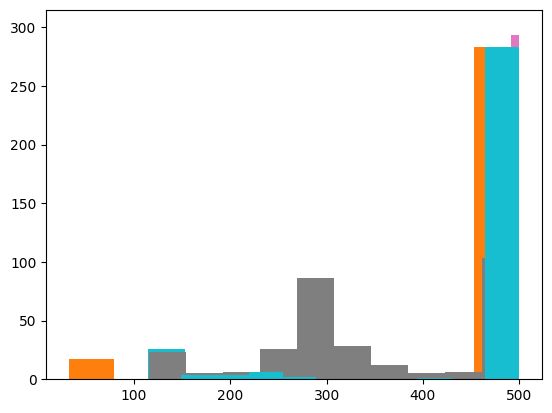

In [111]:
test_rewards = defaultdict(lambda: dict())

for n_trajectories, split_files in result_files.items():
    for split, files in split_files.items():
            reward_model = load_and_combine_vw_models(files, default_hiddens=[8], inputs=6)
            print(f"{n_trajectories} trajectories, split {split}: Loaded a model with params of shape {reward_model.q_param_samples['theta_q'].shape} from {len(files)} files.")
            test_results = gym_test(reward_model, env_name=env_config.env_name, num_actions=2)
            test_rewards[n_trajectories][split] = test_results

In [112]:
split_mean_rewards = {n_trajs: {split: np.mean(rewards) for split, rewards in split_dict.items()} for n_trajs, split_dict in test_rewards.items()}
split_mean_rewards

{10: {4: 500.0, 0: 500.0, 1: 500.0, 2: 500.0, 3: 500.0},
 3: {1: 500.0,
  4: 497.15,
  3: 497.27666666666664,
  0: 500.0,
  2: 468.5933333333333},
 15: {0: 500.0, 2: 474.7866666666667, 3: 500.0, 4: 500.0, 1: 500.0},
 1: {2: 500.0,
  3: 498.85333333333335,
  4: 352.3666666666667,
  1: 500.0,
  0: 484.43},
 7: {3: 500.0, 1: 500.0, 0: 500.0, 2: 500.0, 4: 500.0}}

In [113]:
{n_trajs: np.mean(list(split_files.values())) for n_trajs, split_files in split_mean_rewards.items()}

{10: 500.0, 3: 492.604, 15: 494.9573333333334, 1: 467.13, 7: 500.0}

### Plot the results

In [114]:
vw_means = np.array([np.mean(list(split_mean_rewards[t].values())) for t in traj_nums])
vw_means

array([467.13      , 492.604     , 500.        , 500.        ,
       494.95733333])

In [115]:
vw_stds = np.array([np.std(np.concatenate(list(test_rewards[t].values()))) for t in traj_nums])
vw_stds

array([84.19300703, 47.64355693,  0.        ,  0.        , 47.11128152])

In [116]:
vw_lb = vw_means - vw_stds
vw_ub = vw_means + vw_stds

The following results were taken from the AVRIL paper - the main baseline we're comparing against:

In [117]:
def conv(val: float):
    return 500. - val

avril_rewards = [conv(val) for val in [118, 65, 75, 62, 1]]
avril_ubs = [conv(val) for val in [92, 37, 48, 34, 0]]
avril_lbs = [mean-(ub-mean) for mean, ub in zip(avril_rewards, avril_ubs)]


edm_means = [conv(val) for val in [275., 48., 9., 0., 0.]]
edm_ubs = [conv(val) for val in [139., 5., 0., 0., 0.]]
edm_lbs = [mean-(ub-mean) for mean, ub in zip(edm_means, edm_ubs)]


bc_means = [conv(val) for val in [325., 189., 88., 34., 1.]]
bc_ubs = [conv(val) for val in [212., 75., 12., 0., 0.]]
bc_lbs = [mean-(ub-mean) for mean, ub in zip(bc_means, bc_ubs)]

expert_performance = 500.

In [118]:
traj_nums = [1,3,7,10,15]

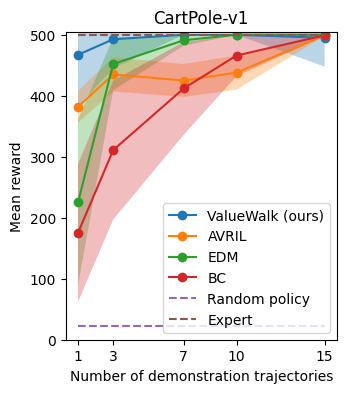

In [119]:
plt.figure(figsize=(3.5, 4))


plt.plot(traj_nums, vw_means, label="ValueWalk (ours)", marker="o")

plt.plot(traj_nums, avril_rewards, label="AVRIL", marker="o")
# 
plt.plot(traj_nums, edm_means, label="EDM", marker="o")
plt.plot(traj_nums, bc_means, label="BC", marker="o")

# plt.plot(traj_nums, avril_means2, label="AVRIL2", marker="o")


plt.plot(traj_nums, [np.mean(random_policy_rewards)]*len(traj_nums), label="Random policy", linestyle="--")
plt.plot(traj_nums, [expert_performance]*len(traj_nums), label="Expert", linestyle="--")

plt.fill_between(traj_nums, vw_lb, vw_ub, alpha=0.3)
plt.fill_between(traj_nums, avril_lbs, avril_ubs, alpha=0.3)
# 
plt.fill_between(traj_nums, edm_lbs, edm_ubs, alpha=0.3)
plt.fill_between(traj_nums, bc_lbs, bc_ubs, alpha=0.3)

plt.xticks(traj_nums)
# plt.xlim(0,15.5)
# set y limits from 0 to 505
plt.ylim(0, 505)

# set x and y axis labels
plt.xlabel("Number of demonstration trajectories")
plt.ylabel("Mean reward")
# Set plot title
plt.title(env_config.env_name)
plt.legend()

# Place legend in the bottom right corner
plt.legend(loc="lower right")

# Save figure into a pdf
plt.savefig("/home/ob/results/irl-torch/birl/carpole_num_trajs_new.pdf")

### Posterior predictive check

In [120]:
D_test = load_avril_demonstrations(env_config.env_name, split="test", to_onehot=True)

plot_actions = torch.eye(2, dtype=torch.float)
plot_states = D_test.states_tensor

Loaded 100 demonstrations


In [121]:
model_name = "avril"

avril_logprobs = {}
avril_entropy = {}
avril_top_action_logprobs = {}

for num_trajs in [1, 3, 7, 10, 15]:
    avril_model_files = glob.glob(str(RESULTS_DIR / f"birl/06a_avril_cartpole_loop_{num_trajs}t_hl64_64*"))

    avril_model_files = [f for f in avril_model_files if "info" not in f]
    
    logprobs = []
    entropies = []
    top_action_logprobs = []
    
    for f in avril_model_files:
        model = torch.load(f)
        avril_action_logprobs = model.boltzmann_action_probs(D_test.states_tensor.float(), plot_actions, beta, discrete_actions=True, return_logprobs=True).detach()
        entropy = -torch.sum(avril_action_logprobs * torch.exp(avril_action_logprobs), dim=-1)
        top_action_logprobs.append(float(torch.max(avril_action_logprobs, dim=-1)[0].mean().item()))

        avril_action_logprobs = avril_action_logprobs.gather(1, torch.argmax(D_test.actions_tensor, dim=-1).unsqueeze(-1)).squeeze(-1)
        
        print(f"{num_trajs}t mean logprob : {avril_action_logprobs.mean()}, entropy: {entropy.mean()}")
        entropies.append(float(entropy.mean().item()))
        
        
        logprobs.append(float(avril_action_logprobs.mean().item()))
        # print(f"{model_name} mean log action density: {torch.log(avril_action_logprobs).mean()}")
    avril_logprobs[num_trajs] = logprobs
    avril_entropy[num_trajs] = entropies
    avril_top_action_logprobs[num_trajs] = top_action_logprobs


1t mean logprob : -0.53916335105896, entropy: 0.64836186170578
1t mean logprob : -0.44278380274772644, entropy: 0.5361682176589966
1t mean logprob : -0.43208906054496765, entropy: 0.4865154027938843
1t mean logprob : -0.4453389048576355, entropy: 0.5384467840194702
1t mean logprob : -0.4948669672012329, entropy: 0.6094639301300049
1t mean logprob : -0.4481073319911957, entropy: 0.5427426099777222
1t mean logprob : -0.44045546650886536, entropy: 0.519004225730896
1t mean logprob : -0.4184293746948242, entropy: 0.4340631365776062
1t mean logprob : -0.4256950318813324, entropy: 0.4959735870361328
1t mean logprob : -0.45538562536239624, entropy: 0.5361989736557007
1t mean logprob : -0.48224595189094543, entropy: 0.595459520816803
1t mean logprob : -0.43421077728271484, entropy: 0.4493676424026489
1t mean logprob : -0.43712118268013, entropy: 0.5173812508583069
1t mean logprob : -0.45893052220344543, entropy: 0.5258427858352661
1t mean logprob : -0.4928373098373413, entropy: 0.6080200672149

In [122]:
# Calculate and print mean per num_trajs
for num_trajs, logprobs in avril_logprobs.items():
    print(f"{num_trajs}t mean logprob : {np.mean(logprobs)}, entropy: {np.mean(avril_entropy[num_trajs])}")

1t mean logprob : -0.45651071071624755, entropy: 0.5362006664276123
3t mean logprob : -0.46458210945129397, entropy: 0.5703915337721507
7t mean logprob : -0.47350833217302957, entropy: 0.5796318610509237
10t mean logprob : -0.474476957321167, entropy: 0.5848575433095297
15t mean logprob : -0.4720406154791514, entropy: 0.5837582389513651


In [123]:
action_ints = torch.argmax(D_test.actions_tensor, dim=-1)
traj_nums = [1, 3, 7, 10, 15]

In [124]:
beta = 3.
vw_action_log_probs = {num_trajs: [] for num_trajs in traj_nums}
vw_entropies = {num_trajs: [] for num_trajs in traj_nums}

model_name = "ValueWalk"

for n_trajectories, split_files in result_files.items():
    for split, files in split_files.items():
        model = load_and_combine_vw_models(files, default_hiddens=[8], inputs=6)
        print(f"{n_trajectories} trajectories, split {split}: Loaded a model with params of shape {reward_model.q_param_samples['theta_q'].shape} from {len(files)} files.")
        
        subset_logprobs = []
        subset_entropies = []
        for i in range(10):
            D_test_small = D_test[(10*i):(10*(i+1))]
            action_ints = torch.argmax(D_test_small.actions_tensor, dim=-1)
            action_logprobs_ba = model.boltzmann_action_probs(D_test_small.states_tensor.float(), plot_actions, beta, return_logprobs=True).detach()
            entropy = -torch.sum(action_logprobs_ba * torch.exp(action_logprobs_ba), dim=-1)
            action_logprobs_ba = action_logprobs_ba.gather(1, action_ints.unsqueeze(-1)).squeeze(-1)
            mean_log_prob = torch.mean(action_logprobs_ba)
            
                    
            subset_logprobs.append(mean_log_prob)
            subset_entropies.append(torch.mean(entropy).item())
            
        vw_action_log_probs[n_trajectories].append(np.mean(subset_logprobs))
        vw_entropies[n_trajectories].append(np.mean(subset_entropies))
        print(f"{model_name} mean log density   : {mean_log_prob}, entropy: {torch.mean(entropy)}")


10 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 65]) from 3 files.
ValueWalk mean log density   : -0.4026474952697754, entropy: 0.4166322648525238
10 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 65]) from 3 files.
ValueWalk mean log density   : -0.4033409059047699, entropy: 0.4178905189037323
10 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 65]) from 2 files.
ValueWalk mean log density   : -0.40289753675460815, entropy: 0.4252794086933136
10 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 65]) from 3 files.
ValueWalk mean log density   : -0.40318992733955383, entropy: 0.41803818941116333
10 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 65]) from 3 files.
ValueWalk mean log density   : -0.40445008873939514, entropy: 0.40351244807243347
3 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 65]) from 4 files.
Va

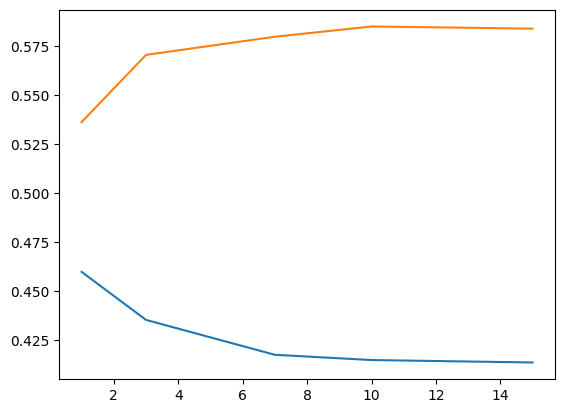

In [125]:
traj_nums = [1,3,7,10,15]

vw_mean_logprobs = {num_trajs: np.mean(logprobs) for num_trajs, logprobs in vw_action_log_probs.items()}
avril_mean_logprobs = {num_trajs: np.mean(logprobs) for num_trajs, logprobs in avril_logprobs.items()}

vw_mean_entropies = [np.mean(entropies) for num_trajs, entropies in vw_entropies.items()]
avril_mean_entropies = [np.mean(entropies) for num_trajs, entropies in avril_entropy.items()]

plt.plot(traj_nums, vw_mean_entropies)
plt.plot(traj_nums, avril_mean_entropies)

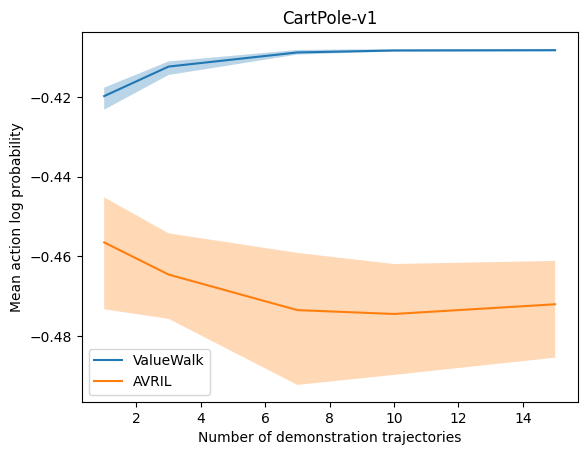

In [127]:
import scipy

traj_nums = [1,3,7,10,15]

# For both, calculate and plot also the 90% confidence interval
# Calculate 90% confidence interval on the mean of the ValueWalk models. Here, we're iterating only over the number of trajectories, and not over the 10 runs. We can use standard scipy bootstrap for this.
vw_means = []
vw_lb = []
vw_ub = []
vw_entropy_means = []
vw_entropy_lb = []
vw_entropy_ub = []
for num_trajs in traj_nums:
    res = scipy.stats.bootstrap((vw_action_log_probs[num_trajs],), statistic=np.mean, confidence_level=0.90)
    vw_means.append(np.mean(vw_action_log_probs[num_trajs]))
    vw_lb.append(res.confidence_interval[0])
    vw_ub.append(res.confidence_interval[1])
    
    res = scipy.stats.bootstrap((vw_entropies[num_trajs],), statistic=np.mean, confidence_level=0.90)
    vw_entropy_means.append(np.mean(vw_entropies[num_trajs]))
    vw_entropy_lb.append(res.confidence_interval[0])
    vw_entropy_ub.append(res.confidence_interval[1])

# Calculate the 90% confidence interval for AVRIL
avril_means = []
avril_lb = []
avril_ub = []
avril_entropy_means = []
avril_entropy_lb = []
avril_entropy_ub = []
for num_trajs in traj_nums:
    res = scipy.stats.bootstrap((avril_logprobs[num_trajs],), statistic=np.mean, confidence_level=0.90)
    avril_means.append(np.mean(avril_logprobs[num_trajs]))
    avril_lb.append(res.confidence_interval[0])
    avril_ub.append(res.confidence_interval[1])
    
    res = scipy.stats.bootstrap((avril_entropy[num_trajs],), statistic=np.mean, confidence_level=0.90)
    avril_entropy_means.append(np.mean(avril_entropy[num_trajs]))
    avril_entropy_lb.append(res.confidence_interval[0])
    avril_entropy_ub.append(res.confidence_interval[1])
    
# Plot the means and confidence intervals
plt.plot(traj_nums, vw_means, label="ValueWalk")
plt.fill_between(traj_nums, vw_lb, vw_ub, alpha=0.3)

plt.plot(list(avril_logprobs.keys()), avril_means, label="AVRIL")
plt.fill_between(list(avril_logprobs.keys()), avril_lb, avril_ub, alpha=0.3)

plt.legend()
plt.xlabel("Number of demonstration trajectories")
plt.ylabel("Mean action log probability")
plt.title(env_config.env_name)

plt.savefig("/home/ob/results/irl-torch/birl/cartpole_action_logprobs_new.pdf")

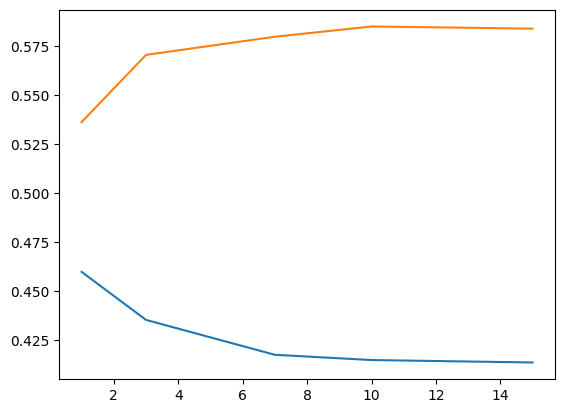

In [128]:
vw_mean_logprobs = {num_trajs: np.mean(logprobs) for num_trajs, logprobs in vw_action_log_probs.items()}
avril_mean_logprobs = {num_trajs: np.mean(logprobs) for num_trajs, logprobs in avril_logprobs.items()}

vw_mean_entropies = [np.mean(entropies) for num_trajs, entropies in vw_entropies.items()]
avril_mean_entropies = [np.mean(entropies) for num_trajs, entropies in avril_entropy.items()]
plt.plot(traj_nums, vw_mean_entropies)
plt.plot(traj_nums, avril_mean_entropies)

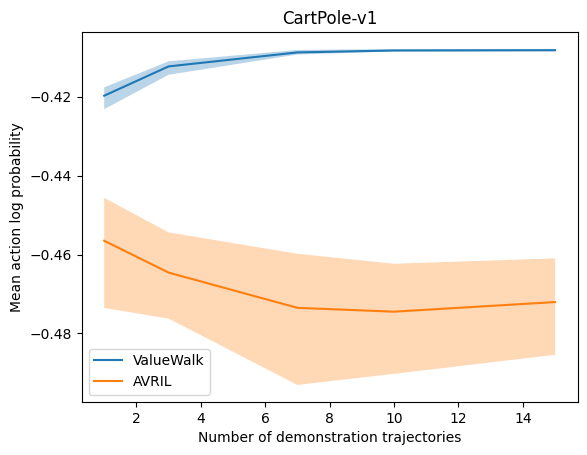

In [129]:
import scipy

traj_nums = [1,3,7,10,15]

# For both, calculate and plot also the 90% confidence interval
# Calculate 90% confidence interval on the mean of the ValueWalk models. Here, we're iterating only over the number of trajectories, and not over the 10 runs. We can use standard scipy bootstrap for this.
vw_means = []
vw_lb = []
vw_ub = []
vw_entropy_means = []
vw_entropy_lb = []
vw_entropy_ub = []
for num_trajs in traj_nums:
    res = scipy.stats.bootstrap((vw_action_log_probs[num_trajs],), statistic=np.mean, confidence_level=0.90)
    vw_means.append(np.mean(vw_action_log_probs[num_trajs]))
    vw_lb.append(res.confidence_interval[0])
    vw_ub.append(res.confidence_interval[1])
    
    res = scipy.stats.bootstrap((vw_entropies[num_trajs],), statistic=np.mean, confidence_level=0.90)
    vw_entropy_means.append(np.mean(vw_entropies[num_trajs]))
    vw_entropy_lb.append(res.confidence_interval[0])
    vw_entropy_ub.append(res.confidence_interval[1])


# Calculate the 90% confidence interval for AVRIL
avril_means = []
avril_lb = []
avril_ub = []
avril_entropy_means = []
avril_entropy_lb = []
avril_entropy_ub = []
for num_trajs in traj_nums:
    res = scipy.stats.bootstrap((avril_logprobs[num_trajs],), statistic=np.mean, confidence_level=0.90)
    avril_means.append(np.mean(avril_logprobs[num_trajs]))
    avril_lb.append(res.confidence_interval[0])
    avril_ub.append(res.confidence_interval[1])
    
    res = scipy.stats.bootstrap((avril_entropy[num_trajs],), statistic=np.mean, confidence_level=0.90)
    avril_entropy_means.append(np.mean(avril_entropy[num_trajs]))
    avril_entropy_lb.append(res.confidence_interval[0])
    avril_entropy_ub.append(res.confidence_interval[1])
    
# Plot the means and confidence intervals
plt.plot(traj_nums, vw_means, label="ValueWalk")
plt.fill_between(traj_nums, vw_lb, vw_ub, alpha=0.3)

plt.plot(list(avril_logprobs.keys()), avril_means, label="AVRIL")
plt.fill_between(list(avril_logprobs.keys()), avril_lb, avril_ub, alpha=0.3)

plt.legend()
plt.xlabel("Number of demonstration trajectories")
plt.ylabel("Mean action log probability")
plt.title(env_config.env_name)

plt.savefig("/home/ob/results/irl-torch/birl/cartpole_action_logprobs_new.pdf")

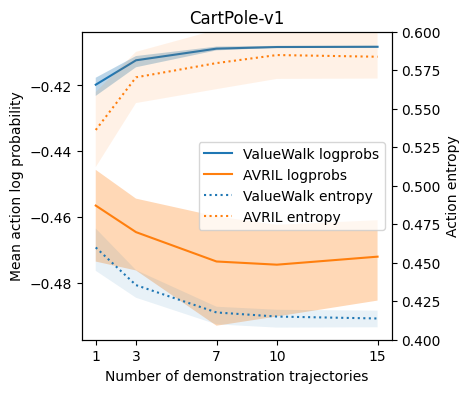

In [135]:
traj_nums = [1, 3, 7, 10, 15]
# Assuming vw_means, vw_lb, vw_ub, avril_means, avril_lb, avril_ub, 
# vw_entropy_means, vw_entropy_lb, vw_entropy_ub, avril_entropy_means, avril_entropy_lb, avril_entropy_ub
# are already calculated as in your code snippet

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(4, 4))

# Plot the means and confidence intervals for action log probabilities on primary axis
ax1.plot(traj_nums, vw_means, label="ValueWalk logprobs")
ax1.fill_between(traj_nums, vw_lb, vw_ub, alpha=0.3)
ax1.plot(traj_nums, avril_means, label="AVRIL logprobs")
ax1.fill_between(traj_nums, avril_lb, avril_ub, alpha=0.3)
ax1.set_xlabel("Number of demonstration trajectories")
ax1.set_ylabel("Mean action log probability")

# Create a secondary axis for entropy values
ax2 = ax1.twinx()
ax2.plot(traj_nums, vw_entropy_means, label="ValueWalk entropy", color="C0", linestyle=":")
ax2.fill_between(traj_nums, vw_entropy_lb, vw_entropy_ub, alpha=0.1)
ax2.plot(traj_nums, avril_entropy_means, label="AVRIL entropy", color="C1", linestyle=":")
ax2.fill_between(traj_nums, avril_entropy_lb, avril_entropy_ub, alpha=0.1)
ax2.set_ylabel("Action entropy")
ax2.set_ylim(0.40, 0.6)

# Adding legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center right')

# Set x ticks to the number of demonstration trajectories
ax1.set_xticks(traj_nums)

plt.title(env_config.env_name) # Replace with your env_config.env_name variable as needed

# Save the plot
plt.savefig("/home/ob/results/irl-torch/birl/cartpole_action_logprobs_and_entropy_new.pdf")

plt.show()

## 2. Acrobot results

In [136]:
beta = 3.
env_config = get_acrobot_env_config()
resolve_configurable_factories(env_config)
env = env_config.env_factory()

In [137]:
all_results = [file_name for file_name in glob.glob(str(RESULTS_DIR / "birl/06b3_vw_acrobot*_paper_*.pt")) 
               if "_10s_" not in file_name and 
               "info" not in file_name and
               ".checkpoint." not in file_name and 
               "evaluation" not in file_name]
all_results

['/home/ob/results/irl-torch/birl/06b3_vw_acrobot_15t_hl16_split1_paper_240612-103934.pt',
 '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_15t_hl16_split0_paper_240612-225547.pt',
 '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_15t_hl16_split4_paper_240612-200954.pt',
 '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_1t_hl16_split2_paper_240611-021341.pt',
 '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_15t_hl16_split3_paper_240612-161307.pt',
 '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_15t_hl16_split2_paper_240613-003626.pt',
 '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_7t_hl16_split2_paper_240611-221350.pt',
 '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_3t_hl16_split1_paper_240611-142752.pt',
 '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_10t_hl16_split3_paper_240612-033239.pt',
 '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_10t_hl16_split3_paper_240612-085649.pt',
 '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_3t_hl16_split3_paper_240611-141952.pt',
 '/

Testing: 100%|██████████| 1000/1000 [00:20<00:00, 48.89it/s]

Mean Reward: -498.396


-498.396

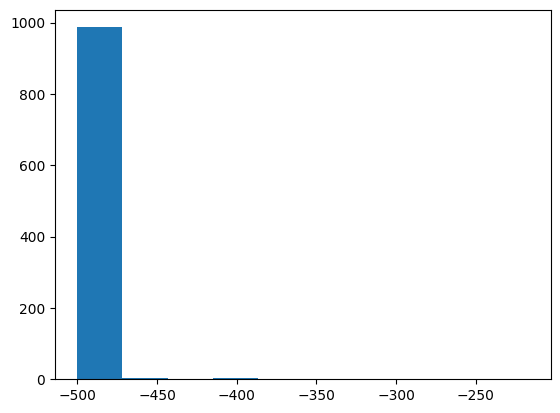

In [138]:

random_policy_rewards = gym_test_random_policy(env_config.env_name)
np.mean(random_policy_rewards)

### Evaluate merged models

In [139]:
# Separate files by number of trajectories and split
result_files = defaultdict(lambda: defaultdict(list))
vw_models = defaultdict(lambda: defaultdict(list))

for file_name in all_results:
    res = re.search(r"_(\d+)t_hl16_split(\d)_", file_name)
    if res is None:
        continue
    n_trajectories, split = res.groups()
    result_files[int(n_trajectories)][int(split)].append(file_name)
result_files

defaultdict(<function __main__.<lambda>()>,
            {15: defaultdict(list,
                         {1: ['/home/ob/results/irl-torch/birl/06b3_vw_acrobot_15t_hl16_split1_paper_240612-103934.pt',
                           '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_15t_hl16_split1_paper_240612-173022.pt',
                           '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_15t_hl16_split1_paper_240612-212747.pt',
                           '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_15t_hl16_split1_paper_240612-143007.pt'],
                          0: ['/home/ob/results/irl-torch/birl/06b3_vw_acrobot_15t_hl16_split0_paper_240612-225547.pt',
                           '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_15t_hl16_split0_paper_240612-130934.pt',
                           '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_15t_hl16_split0_paper_240613-031433.pt',
                           '/home/ob/results/irl-torch/birl/06b3_vw_acrobot_15t_hl16_split0_pap

15 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 30.06it/s]


Mean Reward: -87.02666666666667
15 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:11<00:00, 26.35it/s]


Mean Reward: -82.46
15 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 30.26it/s]


Mean Reward: -83.88
15 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:10<00:00, 29.85it/s]


Mean Reward: -87.26
15 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 31.86it/s]


Mean Reward: -86.07666666666667
1 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:12<00:00, 24.75it/s]


Mean Reward: -93.78666666666666
1 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:10<00:00, 29.16it/s]


Mean Reward: -89.46
1 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 30.34it/s]


Mean Reward: -85.36333333333333
1 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 31.89it/s]


Mean Reward: -84.21
1 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:10<00:00, 28.86it/s]


Mean Reward: -91.4
7 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:10<00:00, 28.39it/s]


Mean Reward: -87.44333333333333
7 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 32.10it/s]


Mean Reward: -85.8
7 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 30.47it/s]


Mean Reward: -84.11333333333333
7 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:10<00:00, 29.72it/s]


Mean Reward: -89.96666666666667
7 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 30.74it/s]


Mean Reward: -86.08333333333333
3 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:08<00:00, 33.38it/s]


Mean Reward: -83.11
3 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 31.30it/s]


Mean Reward: -86.40333333333334
3 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 31.99it/s]


Mean Reward: -83.42333333333333
3 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:10<00:00, 29.81it/s]


Mean Reward: -90.01666666666667
3 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 31.17it/s]


Mean Reward: -87.56
10 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 32.13it/s]


Mean Reward: -82.53
10 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 30.09it/s]


Mean Reward: -87.20333333333333
10 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 31.48it/s]


Mean Reward: -83.63333333333334
10 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 31.14it/s]


Mean Reward: -87.74
10 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.


Testing: 100%|██████████| 300/300 [00:09<00:00, 30.08it/s]


Mean Reward: -84.12


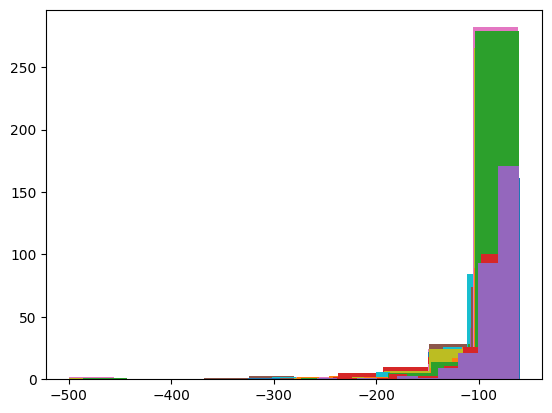

In [140]:
test_rewards = defaultdict(lambda: dict())

for n_trajectories, split_files in result_files.items():
    for split, files in split_files.items():
            reward_model = load_and_combine_vw_models(files, default_hiddens=[16], inputs=9)
            print(f"{n_trajectories} trajectories, split {split}: Loaded a model with params of shape {reward_model.q_param_samples['theta_q'].shape} from {len(files)} files.")
            test_results = gym_test(reward_model, env_name=env_config.env_name, num_actions=3)
            test_rewards[n_trajectories][split] = test_results

In [141]:
split_mean_rewards = {n_trajs: {split: np.mean(rewards) for split, rewards in split_dict.items()} for n_trajs, split_dict in test_rewards.items()}
split_mean_rewards

{15: {1: -87.02666666666667,
  0: -82.46,
  4: -83.88,
  3: -87.26,
  2: -86.07666666666667},
 1: {2: -93.78666666666666,
  3: -89.46,
  1: -85.36333333333333,
  4: -84.21,
  0: -91.4},
 7: {2: -87.44333333333333,
  1: -85.8,
  4: -84.11333333333333,
  3: -89.96666666666667,
  0: -86.08333333333333},
 3: {1: -83.11,
  3: -86.40333333333334,
  0: -83.42333333333333,
  2: -90.01666666666667,
  4: -87.56},
 10: {3: -82.53,
  1: -87.20333333333333,
  0: -83.63333333333334,
  2: -87.74,
  4: -84.12}}

In [142]:
{n_trajs: np.mean(list(split_files.values())) for n_trajs, split_files in split_mean_rewards.items()}

{15: -85.34066666666666,
 1: -88.84400000000001,
 7: -86.68133333333334,
 3: -86.10266666666666,
 10: -85.04533333333333}

### Plot the results

In [143]:
vw_means = np.array([np.mean(list(split_mean_rewards[t].values())) for t in traj_nums])
vw_stds = np.array([np.std(np.concatenate(list(test_rewards[t].values()))) for t in traj_nums])
vw_lb = vw_means - vw_stds
vw_ub = vw_means + vw_stds

In [144]:
traj_nums = [1,3,7,10,15]

# Baseline results from the AVRIL paper
def conv(val: float):
    return 0. - val

avril_rewards = [-296, -149, -97, -91, -90]
avril_ubs = [conv(val) for val in [287, 128, 75, 73, 72]]
avril_lbs = [mean-(ub-mean) for mean, ub in zip(avril_rewards, avril_ubs)]


edm_means = [conv(val) for val in [122., 86., 85., 85., 85.]]
edm_ubs = [conv(val) for val in [94., 86., 85., 85., 85.]]
edm_lbs = [mean-(ub-mean) for mean, ub in zip(edm_means, edm_ubs)]


bc_means = [conv(val) for val in [157., 93., 92., 90., 85.]]
bc_ubs = [conv(val) for val in [94., 93., 92., 90., 85.]]
bc_lbs = [mean-(ub-mean) for mean, ub in zip(bc_means, bc_ubs)]

expert_performance = -87

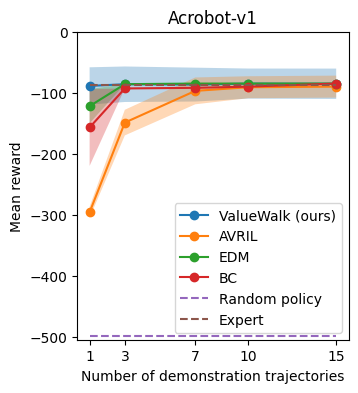

In [145]:
plt.figure(figsize=(3.5, 4))


plt.plot(traj_nums, vw_means, label="ValueWalk (ours)", marker="o")

plt.plot(traj_nums, avril_rewards, label="AVRIL", marker="o")
# 
plt.plot(traj_nums, edm_means, label="EDM", marker="o")
plt.plot(traj_nums, bc_means, label="BC", marker="o")

# plt.plot(traj_nums, avril_means2, label="AVRIL2", marker="o")


plt.plot(traj_nums, [np.mean(random_policy_rewards)]*len(traj_nums), label="Random policy", linestyle="--")
plt.plot(traj_nums, [expert_performance]*len(traj_nums), label="Expert", linestyle="--")

plt.fill_between(traj_nums, vw_lb, vw_ub, alpha=0.3)

plt.fill_between(traj_nums, avril_lbs, avril_ubs, alpha=0.3)
# 
plt.fill_between(traj_nums, edm_lbs, edm_ubs, alpha=0.3)
plt.fill_between(traj_nums, bc_lbs, bc_ubs, alpha=0.3)


plt.ylim(-505, 0)
plt.xticks(traj_nums)
plt.xlabel("Number of demonstration trajectories")
plt.ylabel("Mean reward")
plt.title(env_config.env_name)
plt.legend()

# Place legend in the bottom right corner
plt.legend(loc="lower right")

# Save figure into a pdf
plt.savefig("/home/ob/results/irl-torch/birl/acrobot_num_trajs_new.pdf")
plt.show()

### Posterior predictive check

In [146]:
env_config.env_name

'Acrobot-v1'

In [147]:
D_test = load_avril_demonstrations(env_config.env_name, split="test", to_onehot=True)

plot_actions = torch.eye(3, dtype=torch.float)
plot_states = D_test.states_tensor
model_name = "avril"

avril_logprobs = {}
avril_entropy = {}
avril_top_action_logprobs = {}

for num_trajs in [1, 3, 7, 10, 15]:
    avril_model_files = glob.glob(str(RESULTS_DIR / f"birl/06a2_avril_acrobot_loop_{num_trajs}t_hl64_64*"))
    avril_model_files = [f for f in avril_model_files if "info" not in f]

    logprobs = []
    entropies = []
    top_action_logprobs = []

    for f in avril_model_files:
        model = torch.load(f)
        avril_action_logprobs = model.boltzmann_action_probs(D_test.states_tensor.float(), plot_actions, beta,
                                                             discrete_actions=True, return_logprobs=True).detach()
        entropy = -torch.sum(avril_action_logprobs * torch.exp(avril_action_logprobs), dim=-1)
        top_action_logprobs.append(float(torch.max(avril_action_logprobs, dim=-1)[0].mean().item()))

        avril_action_logprobs = avril_action_logprobs.gather(1, torch.argmax(D_test.actions_tensor, dim=-1).unsqueeze(
            -1)).squeeze(-1)

        print(f"{num_trajs}t mean logprob : {avril_action_logprobs.mean()}, entropy: {entropy.mean()}")
        entropies.append(float(entropy.mean().item()))

        logprobs.append(float(avril_action_logprobs.mean().item()))
        # print(f"{model_name} mean log action density: {torch.log(avril_action_logprobs).mean()}")
    avril_logprobs[num_trajs] = logprobs
    avril_entropy[num_trajs] = entropies
    avril_top_action_logprobs[num_trajs] = top_action_logprobs


Loaded 100 demonstrations
1t mean logprob : -0.6954386830329895, entropy: 0.3031878173351288
1t mean logprob : -1.2450839281082153, entropy: 0.2043815553188324
1t mean logprob : -1.0170402526855469, entropy: 0.21742302179336548
1t mean logprob : -1.0351146459579468, entropy: 0.16814540326595306
1t mean logprob : -1.1351523399353027, entropy: 0.20672009885311127
1t mean logprob : -1.2928745746612549, entropy: 0.13566173613071442
1t mean logprob : -1.1096315383911133, entropy: 0.19399259984493256
1t mean logprob : -1.186455249786377, entropy: 0.18733499944210052
1t mean logprob : -0.61131352186203, entropy: 0.3194481432437897
3t mean logprob : -0.7132991552352905, entropy: 0.24946001172065735
3t mean logprob : -0.6320040225982666, entropy: 0.262762188911438
3t mean logprob : -0.4723672866821289, entropy: 0.3949211835861206
3t mean logprob : -0.7796919941902161, entropy: 0.29523253440856934
3t mean logprob : -0.6656675338745117, entropy: 0.26058951020240784
7t mean logprob : -0.6572040319

In [148]:
beta = 3.
vw_action_log_probs = {num_trajs: [] for num_trajs in traj_nums}
vw_entropies = {num_trajs: [] for num_trajs in traj_nums}

model_name = "ValueWalk"

for n_trajectories, split_files in result_files.items():
    for split, files in split_files.items():
        model = load_and_combine_vw_models(files, default_hiddens=[16], inputs=9)
        print(f"{n_trajectories} trajectories, split {split}: Loaded a model with params of shape {reward_model.q_param_samples['theta_q'].shape} from {len(files)} files.")
        
        subset_logprobs = []
        subset_entropies = []
        for i in range(10):
            D_test_small = D_test[(10*i):(10*(i+1))]
            action_ints = torch.argmax(D_test_small.actions_tensor, dim=-1)
            action_logprobs_ba = model.boltzmann_action_probs(D_test_small.states_tensor.float(), plot_actions, beta, return_logprobs=True).detach()
            entropy = -torch.sum(action_logprobs_ba * torch.exp(action_logprobs_ba), dim=-1)
            action_logprobs_ba = action_logprobs_ba.gather(1, action_ints.unsqueeze(-1)).squeeze(-1)
            mean_log_prob = torch.mean(action_logprobs_ba)
            
                    
            subset_logprobs.append(mean_log_prob)
            subset_entropies.append(torch.mean(entropy).item())
            
        vw_action_log_probs[n_trajectories].append(np.mean(subset_logprobs))
        vw_entropies[n_trajectories].append(np.mean(subset_entropies))
        print(f"{model_name} mean log density   : {mean_log_prob}, entropy: {torch.mean(entropy)}")


15 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.
ValueWalk mean log density   : -0.24620313942432404, entropy: 0.2563951313495636
15 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.
ValueWalk mean log density   : -0.20444020628929138, entropy: 0.294580340385437
15 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.
ValueWalk mean log density   : -0.21183228492736816, entropy: 0.27089157700538635
15 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.
ValueWalk mean log density   : -0.19607694447040558, entropy: 0.2786175608634949
15 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 177]) from 4 files.
ValueWalk mean log density   : -0.2111712098121643, entropy: 0.2823446989059448
1 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 177]) from 4 file

In [149]:
vw_means = []
vw_lb = []
vw_ub = []
vw_entropy_means = []
vw_entropy_lb = []
vw_entropy_ub = []
for num_trajs in traj_nums:
    res = scipy.stats.bootstrap((vw_action_log_probs[num_trajs],), statistic=np.mean, confidence_level=0.90)
    vw_means.append(np.mean(vw_action_log_probs[num_trajs]))
    vw_lb.append(res.confidence_interval[0])
    vw_ub.append(res.confidence_interval[1])
    
    res = scipy.stats.bootstrap((vw_entropies[num_trajs],), statistic=np.mean, confidence_level=0.90)
    vw_entropy_means.append(np.mean(vw_entropies[num_trajs]))
    vw_entropy_lb.append(res.confidence_interval[0])
    vw_entropy_ub.append(res.confidence_interval[1])

# Calculate the 90% confidence interval for AVRIL
avril_means = []
avril_lb = []
avril_ub = []
avril_entropy_means = []
avril_entropy_lb = []
avril_entropy_ub = []
for num_trajs in traj_nums:
    res = scipy.stats.bootstrap((avril_logprobs[num_trajs],), statistic=np.mean, confidence_level=0.90)
    avril_means.append(np.mean(avril_logprobs[num_trajs]))
    avril_lb.append(res.confidence_interval[0])
    avril_ub.append(res.confidence_interval[1])
    
    res = scipy.stats.bootstrap((avril_entropy[num_trajs],), statistic=np.mean, confidence_level=0.90)
    avril_entropy_means.append(np.mean(avril_entropy[num_trajs]))
    avril_entropy_lb.append(res.confidence_interval[0])
    avril_entropy_ub.append(res.confidence_interval[1])

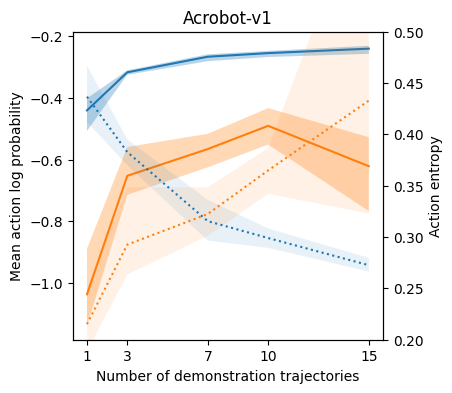

In [151]:
traj_nums = [1, 3, 7, 10, 15]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(4, 4))

# Plot the means and confidence intervals for action log probabilities on primary axis
ax1.plot(traj_nums, vw_means, label="ValueWalk")
ax1.fill_between(traj_nums, vw_lb, vw_ub, alpha=0.3)
ax1.plot(traj_nums, avril_means, label="AVRIL")
ax1.fill_between(traj_nums, avril_lb, avril_ub, alpha=0.3)
ax1.set_xlabel("Number of demonstration trajectories")
ax1.set_ylabel("Mean action log probability")

# Create a secondary axis for entropy values
ax2 = ax1.twinx()
ax2.plot(traj_nums, vw_entropy_means, label="ValueWalk entropy", color="C0", linestyle=":")
ax2.fill_between(traj_nums, vw_entropy_lb, vw_entropy_ub, alpha=0.1)
ax2.plot(traj_nums, avril_entropy_means, label="AVRIL entropy", color="C1", linestyle=":")
ax2.fill_between(traj_nums, avril_entropy_lb, avril_entropy_ub, alpha=0.1)
ax2.set_ylabel("Action entropy")
ax2.set_ylim(0.2, 0.5)

# Adding legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines + lines2, labels + labels2, loc='center right')

# Set x ticks to the number of demonstration trajectories
ax1.set_xticks(traj_nums)

plt.title(env_config.env_name)

# Save the plot
plt.savefig("/home/ob/results/irl-torch/birl/acrobot_action_logprobs_and_entropy_new.pdf")

plt.show()

## 3. Lunar Lander results

In [53]:
env_config = get_lunar_lander_env_config()

Gather result files for Lunar Lander:

In [21]:
all_result_files = [file_name for file_name in glob.glob(str(RESULTS_DIR / "birl/06b_vw_lunar*_paper_*.pt")) if 
               "_10s_" not in file_name and 
               "info" not in file_name and 
               "checkpoint" not in file_name and
               "evaluation" not in file_name
               ]
all_result_files

['/home/ob/results/irl-torch/birl/06b_vw_lunar_lander_gamma0.95_beta3e+00_7t_split4_rep0_hl24_24_scale1_lsp03_c56_paper_240610-234637.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_lunar_lander_gamma0.95_beta3e+00_15t_split2_rep1_hl24_24_scale1_lsp03_c0_paper_240612-182817.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_lunar_lander_gamma0.95_beta3e+00_7t_split0_rep0_hl24_24_scale1_lsp03_c32_paper_240610-234637.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_lunar_lander_gamma0.95_beta3e+00_7t_split4_rep1_hl24_24_scale1_lsp03_c59_paper_240613-151428.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_lunar_lander_gamma0.95_beta3e+00_10t_split3_rep0_hl24_24_scale1_lsp03_c0_paper_240614-021232.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_lunar_lander_gamma0.95_beta3e+00_1t_split3_rep0_hl24_24_scale1_lsp03_c48_paper_240610-234637.pt',
 '/home/ob/results/irl-torch/birl/06b_vw_lunar_lander_gamma0.95_beta3e+00_1t_split4_rep0_hl24_24_scale1_lsp03_c54_paper_240610-234637.pt',
 '/home/ob/results/irl-torc

Evaluate random policy:

Testing: 100%|██████████| 1000/1000 [00:02<00:00, 481.25it/s]

Mean Reward: -179.53283332604877


-179.53283332604857

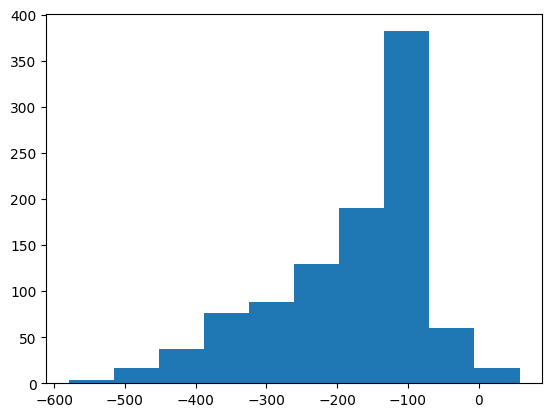

In [24]:
random_policy_rewards = gym_test_random_policy(env_config.env_name)
np.mean(random_policy_rewards)

### Evaluate merged models

In [36]:
# Separate files by number of trajectories and split
result_files = defaultdict(lambda: defaultdict(list))

for file_name in all_result_files:            
    gamma, beta, n_trajectories, split, hl, scale, ls, series = re.search(r"gamma([\d\.]+)_beta([\de\+]+)_(\d+)t_split(\d)_rep\d_hl([\d_]+)_scale(\d)_ls(p\d+)_c\d+_([^_]+)", file_name).groups()
    result_files[int(n_trajectories)][int(split)].append(file_name)
    
result_files

defaultdict(<function __main__.<lambda>()>,
            {7: defaultdict(list,
                         {4: ['/home/ob/results/irl-torch/birl/06b_vw_lunar_lander_gamma0.95_beta3e+00_7t_split4_rep0_hl24_24_scale1_lsp03_c56_paper_240610-234637.pt',
                           '/home/ob/results/irl-torch/birl/06b_vw_lunar_lander_gamma0.95_beta3e+00_7t_split4_rep1_hl24_24_scale1_lsp03_c59_paper_240613-151428.pt',
                           '/home/ob/results/irl-torch/birl/06b_vw_lunar_lander_gamma0.95_beta3e+00_7t_split4_rep1_hl24_24_scale1_lsp03_c56_paper_240613-120307.pt',
                           '/home/ob/results/irl-torch/birl/06b_vw_lunar_lander_gamma0.95_beta3e+00_7t_split4_rep0_hl24_24_scale1_lsp03_c59_paper_240610-234637.pt'],
                          0: ['/home/ob/results/irl-torch/birl/06b_vw_lunar_lander_gamma0.95_beta3e+00_7t_split0_rep0_hl24_24_scale1_lsp03_c32_paper_240610-234637.pt',
                           '/home/ob/results/irl-torch/birl/06b_vw_lunar_lander_gamma0.95_

7 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [00:53<00:00,  5.58it/s]


Mean Reward: 266.85979504388274
7 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [00:59<00:00,  5.08it/s]


Mean Reward: 263.91399893824683
7 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [00:50<00:00,  5.94it/s]


Mean Reward: 221.10647593353477
7 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [00:48<00:00,  6.18it/s]


Mean Reward: 253.69048679208217
7 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [00:50<00:00,  5.97it/s]


Mean Reward: 267.423023445802
15 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 937]) from 2 files.


Testing: 100%|██████████| 300/300 [00:54<00:00,  5.46it/s]


Mean Reward: 260.63746489147235
15 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 937]) from 2 files.


Testing: 100%|██████████| 300/300 [00:59<00:00,  5.03it/s]


Mean Reward: 266.16912618457724
15 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 937]) from 2 files.


Testing: 100%|██████████| 300/300 [00:46<00:00,  6.43it/s]


Mean Reward: 271.12741187092877
15 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 937]) from 2 files.


Testing: 100%|██████████| 300/300 [00:47<00:00,  6.28it/s]


Mean Reward: 249.83943198187097
15 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 937]) from 2 files.


Testing: 100%|██████████| 300/300 [00:53<00:00,  5.60it/s]


Mean Reward: 267.56971811912433
10 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 937]) from 2 files.


Testing: 100%|██████████| 300/300 [00:50<00:00,  5.94it/s]


Mean Reward: 233.90630177632542
10 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 937]) from 3 files.


Testing: 100%|██████████| 300/300 [00:43<00:00,  6.90it/s]


Mean Reward: 271.0436635447382
10 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 937]) from 2 files.


Testing: 100%|██████████| 300/300 [00:42<00:00,  7.08it/s]


Mean Reward: 275.15875669871485
10 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 937]) from 2 files.


Testing: 100%|██████████| 300/300 [00:46<00:00,  6.43it/s]


Mean Reward: 267.31685153363753
1 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [00:54<00:00,  5.46it/s]


Mean Reward: -362.8694760282321
1 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [00:35<00:00,  8.49it/s]


Mean Reward: -163.1173516951143
1 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [01:16<00:00,  3.94it/s]


Mean Reward: -1.533592705111564
1 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [00:36<00:00,  8.28it/s]


Mean Reward: -14.432406883660217
1 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [00:51<00:00,  5.87it/s]


Mean Reward: -314.244601141074
3 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [00:37<00:00,  7.95it/s]


Mean Reward: 102.28754901491406
3 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [00:47<00:00,  6.35it/s]


Mean Reward: 207.16464184099533
3 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [01:13<00:00,  4.09it/s]


Mean Reward: 207.26318547102298
3 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [00:57<00:00,  5.23it/s]


Mean Reward: 206.82878451765373
3 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.


Testing: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]

Mean Reward: -45.4386729722265


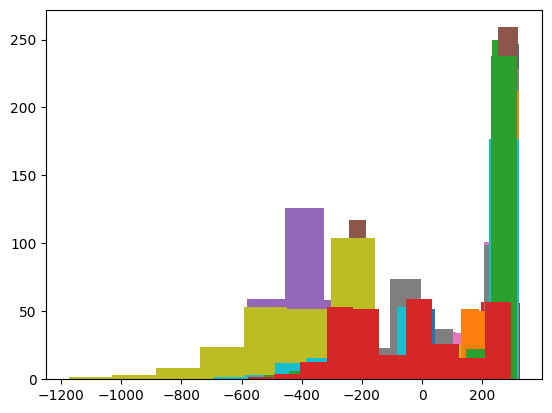

In [27]:
test_rewards = defaultdict(lambda: dict())

for n_trajectories, split_files in result_files.items():
    for split, files in split_files.items():
            reward_model = load_and_combine_vw_models(files)
            print(f"{n_trajectories} trajectories, split {split}: Loaded a model with params of shape {reward_model.q_param_samples['theta_q'].shape} from {len(files)} files.")
            test_results = gym_test(reward_model, aggregation_fn=lambda x: torch.median(x, dim=-1)[0])
            test_rewards[n_trajectories][split] = test_results

In [37]:
split_mean_rewards = {n_trajs: {split: np.mean(rewards) for split, rewards in split_dict.items()} for n_trajs, split_dict in test_rewards.items()}
split_mean_rewards

{7: {4: 266.85979504388274,
  0: 263.91399893824683,
  3: 221.10647593353463,
  2: 253.69048679208228,
  1: 267.423023445802},
 15: {2: 260.6374648914722,
  3: 266.1691261845772,
  0: 271.1274118709286,
  4: 249.83943198187083,
  1: 267.5697181191243},
 10: {3: 233.90630177632542,
  0: 271.0436635447381,
  2: 275.1587566987144,
  1: 267.3168515336375},
 1: {3: -362.8694760282324,
  4: -163.1173516951144,
  0: -1.5335927051115634,
  2: -14.432406883660217,
  1: -314.244601141074},
 3: {2: 102.2875490149141,
  1: 207.16464184099533,
  4: 207.26318547102306,
  0: 206.8287845176537,
  3: -45.4386729722265}}

In [38]:
{n_trajs: np.mean(list(split_files.values())) for n_trajs, split_files in split_mean_rewards.items()}

{7: 254.5987560307097,
 15: 263.0686306095946,
 10: 261.8563933883538,
 1: -171.2394856906385,
 3: 135.62109757447195}

### Plotting

In [31]:
vw_means = np.array([np.mean(list(split_mean_rewards[t].values())) for t in traj_nums])
vw_means

array([-171.23948569,  135.62109757,  254.59875603,  261.85639339,
        263.06863061])

In [32]:
vw_stds = np.array([np.std(np.concatenate(list(test_rewards[t].values()))) for t in traj_nums])
vw_stds

array([265.3906206 , 198.63128919,  82.58343109,  63.38540973,
        66.61282606])

In [33]:
vw_lb = vw_means - vw_stds
vw_ub = vw_means + vw_stds

In [34]:
# Results of previous methods from the AVRIL paper:
def conv(val: float):
    return 300. - val

avril_reported_means = [conv(val) for val in [421., 191., 99., 74., 61.]]
avril_reported_ubs = [conv(val) for val in [284., 55., 7., 3., 0.]]
avril_reported_lbs = [mean-(ub-mean) for mean, ub in zip(avril_reported_means, avril_reported_ubs)]

bc_means = [conv(val) for val in [335., 126., 73., 58., 59.]]
bc_ubs = [conv(val) for val in [272., 87.5, 46., 39., 39.]]
bc_lbs = [mean-(ub-mean) for mean, ub in zip(bc_means, bc_ubs)]

edm_means = [6., 190., 240., 255., 248.]
edm_ubs = [63., 213., 253., 262., 261.]
edm_lbs = [-48., 167., 227., 239., 241.]

expert_performance = 269. 

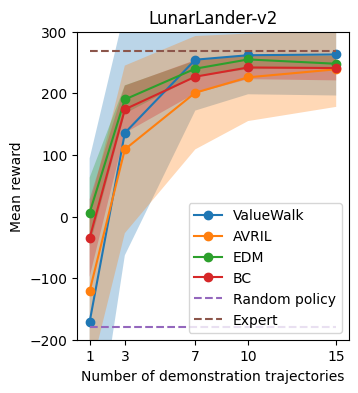

In [35]:
plt.figure(figsize=(3.5, 4))

plt.plot(traj_nums, vw_means, label="ValueWalk", marker="o")

plt.plot(traj_nums, avril_reported_means, label="AVRIL", marker="o")

plt.plot(traj_nums, edm_means, label="EDM", marker="o")
plt.plot(traj_nums, bc_means, label="BC", marker="o")

plt.plot(traj_nums, [np.mean(random_policy_rewards)]*len(traj_nums), label="Random policy", linestyle="--")
plt.plot(traj_nums, [expert_performance]*len(traj_nums), label="Expert", linestyle="--")

plt.fill_between(traj_nums, vw_lb, vw_ub, alpha=0.3)
plt.fill_between(traj_nums, avril_reported_lbs, avril_reported_ubs, alpha=0.3)
plt.fill_between(traj_nums, edm_lbs, edm_ubs, alpha=0.3)
plt.fill_between(traj_nums, bc_lbs, bc_ubs, alpha=0.3)

# Set x ticks to be the number of demonstration trajectories
plt.xticks(traj_nums)

# plt.xlim(0,15.5)
plt.ylim(-200, 300)

plt.xlabel("Number of demonstration trajectories")
plt.ylabel("Mean reward")
plt.title(env_config.env_name)
plt.legend(loc="lower right")

plt.savefig("/home/ob/results/irl-torch/birl/lander_num_trajs_new.pdf")

### Posterior predictive

In [58]:
env_config.env_name

'LunarLander-v2'

In [59]:
D_test = load_avril_demonstrations(env_config.env_name, split="test", to_onehot=True)

plot_actions = torch.eye(4, dtype=torch.float)
plot_states = D_test.states_tensor

Loaded 100 demonstrations


In [63]:
model_name = "avril"

avril_logprobs = {}
avril_entropy = {}
avril_top_action_logprobs = {}

for num_trajs in [1, 3, 7, 10, 15]:
    avril_model_files = glob.glob(str(RESULTS_DIR / f"birl/06a3_avril_lunar_lander_loop_{num_trajs}t_split*"))
    avril_model_files = [f for f in avril_model_files if "info" not in f]

    logprobs = []
    entropies = []
    top_action_logprobs = []

    for f in avril_model_files:
        model = torch.load(f)
        avril_action_logprobs = model.boltzmann_action_probs(D_test.states_tensor.float(), plot_actions, beta,
                                                             discrete_actions=True, return_logprobs=True).detach()
        entropy = -torch.sum(avril_action_logprobs * torch.exp(avril_action_logprobs), dim=-1)
        top_action_logprobs.append(float(torch.max(avril_action_logprobs, dim=-1)[0].mean().item()))

        avril_action_logprobs = avril_action_logprobs.gather(1, torch.argmax(D_test.actions_tensor, dim=-1).unsqueeze(
            -1)).squeeze(-1)

        print(f"{num_trajs}t mean logprob : {avril_action_logprobs.mean()}, entropy: {entropy.mean()}")
        entropies.append(float(entropy.mean().item()))

        logprobs.append(float(avril_action_logprobs.mean().item()))
        # print(f"{model_name} mean log action density: {torch.log(avril_action_logprobs).mean()}")
    avril_logprobs[num_trajs] = logprobs
    avril_entropy[num_trajs] = entropies
    avril_top_action_logprobs[num_trajs] = top_action_logprobs

1t mean logprob : -7.103645324707031, entropy: 0.14732179045677185
1t mean logprob : -10.68213939666748, entropy: 0.16529326140880585
1t mean logprob : -5.348207950592041, entropy: 0.2718144655227661
1t mean logprob : -9.45484733581543, entropy: 0.18542899191379547
1t mean logprob : -8.051855087280273, entropy: 0.20823681354522705
1t mean logprob : -17.60118293762207, entropy: 0.07710173726081848
1t mean logprob : -14.567254066467285, entropy: 0.16955755650997162
1t mean logprob : -2.3036978244781494, entropy: 0.6244148015975952
1t mean logprob : -5.893759727478027, entropy: 0.23920628428459167
1t mean logprob : -5.843641757965088, entropy: 0.32360655069351196
1t mean logprob : -21.37376594543457, entropy: 0.06422871351242065
3t mean logprob : -1.3490104675292969, entropy: 0.4994262158870697
3t mean logprob : -1.7115298509597778, entropy: 0.5032340884208679
3t mean logprob : -2.210205316543579, entropy: 0.4030427038669586
3t mean logprob : -4.082785129547119, entropy: 0.429147213697433

In [68]:
vw_action_log_probs = {num_trajs: [] for num_trajs in traj_nums}
vw_entropies = {num_trajs: [] for num_trajs in traj_nums}

model_name = "ValueWalk"

for n_trajectories, split_files in result_files.items():
    for split, files in split_files.items():
        model = load_and_combine_vw_models(files)
        print(f"{n_trajectories} trajectories, split {split}: Loaded a model with params of shape {reward_model.q_param_samples['theta_q'].shape} from {len(files)} files.")
        
        subset_logprobs = []
        subset_entropies = []
        for i in range(10):
            D_test_small = D_test[(10*i):(10*(i+1))]
            action_ints = torch.argmax(D_test_small.actions_tensor, dim=-1)
            action_logprobs_ba = model.boltzmann_action_probs(D_test_small.states_tensor.float(), plot_actions, beta, return_logprobs=True).detach()
            entropy = -torch.sum(action_logprobs_ba * torch.exp(action_logprobs_ba), dim=-1)
            action_logprobs_ba = action_logprobs_ba.gather(1, action_ints.unsqueeze(-1)).squeeze(-1)
            mean_log_prob = torch.mean(action_logprobs_ba)
            
                    
            subset_logprobs.append(mean_log_prob)
            subset_entropies.append(torch.mean(entropy).item())
            
        vw_action_log_probs[n_trajectories].append(np.mean(subset_logprobs))
        vw_entropies[n_trajectories].append(np.mean(subset_entropies))
        print(f"{model_name} mean log density   : {mean_log_prob}, entropy: {torch.mean(entropy)}")


7 trajectories, split 4: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.
ValueWalk mean log density   : -0.5149522423744202, entropy: 0.5078274011611938
7 trajectories, split 0: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.
ValueWalk mean log density   : -0.4552973210811615, entropy: 0.5687806010246277
7 trajectories, split 3: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.
ValueWalk mean log density   : -0.5056448578834534, entropy: 0.514598548412323
7 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.
ValueWalk mean log density   : -0.5806600451469421, entropy: 0.6707218289375305
7 trajectories, split 1: Loaded a model with params of shape torch.Size([2000, 937]) from 4 files.
ValueWalk mean log density   : -0.5620625019073486, entropy: 0.6620789766311646
15 trajectories, split 2: Loaded a model with params of shape torch.Size([2000, 937]) from 2 files.
ValueW

In [69]:
vw_action_log_probs

{1: [-1.2515008, -1.1195505, -1.0998213, -1.169246, -1.3260069],
 3: [-1.1069769, -0.75469804, -0.93705094, -0.7819993, -0.90452206],
 7: [-0.59595835, -0.5519339, -0.6183099, -0.6381919, -0.5891495],
 10: [-0.7125202, -0.55403733, -0.7148139, -0.6491734, -0.6633841],
 15: [-0.5271952, -0.46562713, -0.4930641, -0.41778547, -0.5503043]}

In [70]:
import scipy

vw_means = []
vw_lb = []
vw_ub = []
vw_entropy_means = []
vw_entropy_lb = []
vw_entropy_ub = []
for num_trajs in traj_nums:
    res = scipy.stats.bootstrap((vw_action_log_probs[num_trajs],), statistic=np.mean, confidence_level=0.90)
    vw_means.append(np.mean(vw_action_log_probs[num_trajs]))
    vw_lb.append(res.confidence_interval[0])
    vw_ub.append(res.confidence_interval[1])
    
    res = scipy.stats.bootstrap((vw_entropies[num_trajs],), statistic=np.mean, confidence_level=0.90)
    vw_entropy_means.append(np.mean(vw_entropies[num_trajs]))
    vw_entropy_lb.append(res.confidence_interval[0])
    vw_entropy_ub.append(res.confidence_interval[1])

# Calculate the 90% confidence interval for AVRIL
avril_means = []
avril_lb = []
avril_ub = []
avril_entropy_means = []
avril_entropy_lb = []
avril_entropy_ub = []
for num_trajs in traj_nums:
    res = scipy.stats.bootstrap((avril_logprobs[num_trajs],), statistic=np.mean, confidence_level=0.90)
    avril_means.append(np.mean(avril_logprobs[num_trajs]))
    avril_lb.append(res.confidence_interval[0])
    avril_ub.append(res.confidence_interval[1])
    
    res = scipy.stats.bootstrap((avril_entropy[num_trajs],), statistic=np.mean, confidence_level=0.90)
    avril_entropy_means.append(np.mean(avril_entropy[num_trajs]))
    avril_entropy_lb.append(res.confidence_interval[0])
    avril_entropy_ub.append(res.confidence_interval[1])

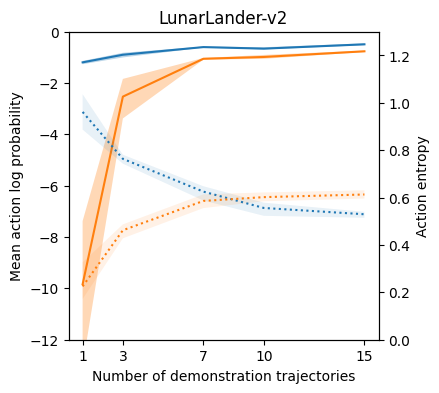

In [73]:
traj_nums = [1, 3, 7, 10, 15]
# Assuming vw_means, vw_lb, vw_ub, avril_means, avril_lb, avril_ub, 
# vw_entropy_means, vw_entropy_lb, vw_entropy_ub, avril_entropy_means, avril_entropy_lb, avril_entropy_ub
# are already calculated as in your code snippet

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(4, 4))

# Plot the means and confidence intervals for action log probabilities on primary axis
ax1.plot(traj_nums, vw_means, label="ValueWalk")
ax1.fill_between(traj_nums, vw_lb, vw_ub, alpha=0.3)
ax1.plot(traj_nums, avril_means, label="AVRIL")
ax1.fill_between(traj_nums, avril_lb, avril_ub, alpha=0.3)
ax1.set_xlabel("Number of demonstration trajectories")
ax1.set_ylabel("Mean action log probability")
ax1.set_ylim(-12, 0)


# Create a secondary axis for entropy values
ax2 = ax1.twinx()
ax2.plot(traj_nums, vw_entropy_means, label="ValueWalk entropy", color="C0", linestyle=":")
ax2.fill_between(traj_nums, vw_entropy_lb, vw_entropy_ub, alpha=0.1)
ax2.plot(traj_nums, avril_entropy_means, label="AVRIL entropy", color="C1", linestyle=":")
ax2.fill_between(traj_nums, avril_entropy_lb, avril_entropy_ub, alpha=0.1)
ax2.set_ylabel("Action entropy")
ax2.set_ylim(0, 1.3)

# Adding legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines + lines2, labels + labels2, loc='center right')

# Set x ticks to the number of demonstration trajectoriescartpole
ax1.set_xticks(traj_nums)

plt.title(env_config.env_name)

# Save the plot
plt.savefig("/home/ob/results/irl-torch/birl/lunar_lander_action_logprobs_and_entropy_new.pdf")

plt.show()